In [188]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy
import sklearn
import sys
import tqdm

sys.path.append("..")
import localmodule

In [13]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob(os.path.join(
    data_dir, "imitations_participant*.mat"))
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

100%|██████████| 19/19 [00:25<00:00,  1.37s/it]


In [432]:
participant_id = 0
imitation_id = 0
hop_length = 512
half_event_length = 4096
sr = 44100
n_events = 2
n_mfcc = 12

mfcc_tensor = np.zeros((n_mfcc, n_events, n_participants, n_imitations))

for participant_id in tqdm.tqdm(range(n_participants)):
    for imitation_id in range(n_imitations):
        imitation_waveform = imitation_matrix[participant_id, imitation_id]

        rms = np.ravel(librosa.feature.rmse(
            imitation_waveform, frame_length=2*hop_length, hop_length=hop_length))
        sorting_indices = rms.argsort(axis=0)[::-1]

        for event_id in range(n_events):
            event_start = max(0, sorting_indices[event_id] * hop_length - half_event_length)
            event_stop = min(len(imitation_waveform),
                             sorting_indices[event_id] * hop_length + half_event_length)
            event_length = event_stop - event_start
            event_waveform = imitation_waveform[event_start:event_stop] * scipy.signal.hann(event_length)
            mfcc = librosa.feature.mfcc(y=event_waveform, n_mels=40, n_mfcc=(1+n_mfcc), sr=sr)[1:, :]
            mfcc_tensor[:, event_id, participant_id, imitation_id] = np.mean(mfcc, axis=1)
            
species_tensor = np.tile(species_matrix, (n_events, 1, 1))
mfcc_X = np.reshape(mfcc_tensor, (n_mfcc, n_events*n_participants*n_imitations)).T
mfcc_y = np.ravel(species_tensor) - 1

100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


In [433]:
# Principal component analysis

pca_model = sklearn.decomposition.PCA().fit(mfcc_X)
pca_X = pca_model.transform(mfcc_X)

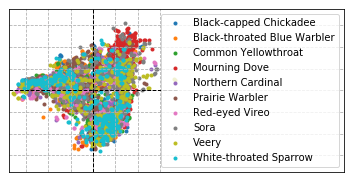

In [434]:
# Visualization of species
metadata_path = os.path.join(data_dir, 'BirdVox-imitation_metadata.mat')
with h5py.File(metadata_path) as h5_file:
    species_strings = [
        " ".join([x.capitalize() for x in
        "".join(list(map(chr, h5_file["#refs#"][h5_file["meta"]["species"]["speciesName"][i][0]][:]))).split("_")])
         for i in range(n_species)
    ]

xmax = 10*(np.max(10+np.abs(pca_X))//10)
n_species = len(np.unique(species_tensor))

plt.figure(figsize=(6, 3))
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for species_id in range(n_species):
    plt.scatter(
        pca_X[mfcc_y==species_id, 0], pca_X[mfcc_y==species_id, 1],
        marker='.', alpha=1.0, cmap='Set1', label=species_strings[species_id])
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 225)
plt.ylim(-75, 75)
plt.legend()
plt.grid(linestyle='--')

plt.savefig("vihar2019_pca_species.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_pca_species.eps", bbox_inches="tight")

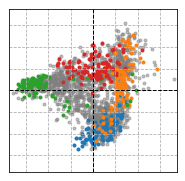

In [436]:
# Visualization of participants
participant_tensor = np.tile(np.arange(0, n_events*n_participants), (n_imitations, 1)).T
participant_y = np.ravel(participant_tensor)
participant_subset = [7, 10, 11, 12]
participant_complementary_subset = [
    x for x in range(n_participants)
    if x not in participant_subset]

plt.figure(figsize=(3, 3))
plt.plot([0, 0], [-xmax, xmax], '--', color='k', linewidth=1.0)
plt.plot([-xmax, xmax], [0, 0], '--', color='k', linewidth=1.0)
for participant_id in participant_complementary_subset:
    plt.scatter(
        pca_X[participant_y==participant_id, 0], pca_X[participant_y==participant_id, 1],
        marker='.', alpha=0.5, color='gray', label=participant_id)
for participant_id in participant_subset:
    plt.scatter(
        pca_X[participant_y==participant_id, 0], pca_X[participant_y==participant_id, 1],
        marker='.', alpha=1.0, cmap='gray', label=participant_id)
plt.gca().set_xticks(range(-300, 300, 20))
plt.gca().set_yticks(range(-300, 300, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.grid(linestyle='--')

plt.savefig("vihar2019_pca_participants.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_pca_participants.eps", bbox_inches="tight")

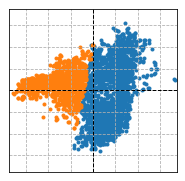

In [437]:
# Visualization of k-means clusters
n_clusters = 2
kmeans_model = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(mfcc_X)
kmeans_y = kmeans_model.labels_

plt.figure(figsize=(3, 3))
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for cluster_id in range(n_clusters):
    plt.scatter(
        pca_X[kmeans_y==cluster_id, 0], pca_X[kmeans_y==cluster_id, 1],
        marker='.', alpha=1.0, label=species_strings[species_id])
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.grid(linestyle='--')

plt.savefig("vihar2019_pca_clusters.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_pca_clusters.eps", bbox_inches="tight")

In [438]:
h5_file.close()